# IForest modelo base umbral

## 1. Importación de librerías

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.cluster import KMeans
from random import sample
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import shap

#Mostrar todas las columnas de un dataframe
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 2. Importación de data

In [3]:
#Seleccionar ruta de la data
dataframe = pd.read_csv(r'C:\GIT_Cumplimiento\epic\EPIC003\data\modeling\03_train_v4.csv', encoding='latin')
dataframe.shape

(13516, 13)

In [4]:
#Visualizo tabla importada
dataframe.head()

,Unnamed: 0,PERIODO,CODCLAVECIC,NBRCLIORDENANTE,SEGMENTO,MTO_TRANSF,CTD_OPE,FLG_PEP,FLG_PROF,FLG_PAR,FLG_PERFIL,CTDEVAL,FLG_PAIS
0,0,202206,812,CORTES DE POLAR SANDRA MIRIAN,ENALTA,100000.00,1,0,1,2,0,0,1
1,8,202209,1750,CONROY DE MARSANO MARIA TERESA,PRIVADA,17357.00,1,0,0,0,0,15,0
2,9,202204,1973,APARCANA HERRERA MARIELA VILMA,CONSUMO,13931.65,1,0,1,0,0,0,0
3,12,202204,2249,DANERI PREIS GUSTAVO,ENALTA,13275.00,1,0,1,0,0,5,0
4,14,202208,2374,FIEDLER VASQUEZ-MEJIA PAUL,ENALTA,10670.96,2,0,1,0,0,0,0


## 3. Universo de riesgo

In [5]:
#Importo modelo kmeans final
import pickle 
loaded_KM = pickle.load(open(r'KMeans1_9seg_stairs.model', "rb"))

In [6]:
#Selecciono solo las variables que necesita el modelo
dataset=dataframe[['MTO_TRANSF', 'CTD_OPE', 'FLG_PEP', 'FLG_PROF', 'FLG_PERFIL','CTDEVAL', 'FLG_PAIS']]

#Estandarizo variables
dataset_cluster = MinMaxScaler().fit_transform(dataset)

In [7]:
#Aplico el modelo cargado sobre la data. Columna Outlier es la que tiene el resultado del modelo
dataframe['N_CLUSTER']=loaded_KM.predict(dataset_cluster)
dataframe.head()


,Unnamed: 0,PERIODO,CODCLAVECIC,NBRCLIORDENANTE,SEGMENTO,MTO_TRANSF,CTD_OPE,FLG_PEP,FLG_PROF,FLG_PAR,FLG_PERFIL,CTDEVAL,FLG_PAIS,N_CLUSTER
0,0,202206,812,CORTES DE POLAR SANDRA MIRIAN,ENALTA,100000.00,1,0,1,2,0,0,1,1
1,8,202209,1750,CONROY DE MARSANO MARIA TERESA,PRIVADA,17357.00,1,0,0,0,0,15,0,2
2,9,202204,1973,APARCANA HERRERA MARIELA VILMA,CONSUMO,13931.65,1,0,1,0,0,0,0,3
3,12,202204,2249,DANERI PREIS GUSTAVO,ENALTA,13275.00,1,0,1,0,0,5,0,3
4,14,202208,2374,FIEDLER VASQUEZ-MEJIA PAUL,ENALTA,10670.96,2,0,1,0,0,0,0,3


In [9]:
#Defino Universo basado en clusters de riesgo seleccionados
dataseg=dataframe[dataframe['N_CLUSTER'].isin([4,5,6,7,8])]
dataseg.shape

(1217, 14)

In [10]:
#Visualizo dataset
dataseg.head()

,Unnamed: 0,PERIODO,CODCLAVECIC,NBRCLIORDENANTE,SEGMENTO,MTO_TRANSF,CTD_OPE,FLG_PEP,FLG_PROF,FLG_PAR,FLG_PERFIL,CTDEVAL,FLG_PAIS,N_CLUSTER
8,39,202206,4319,SORIA SUAREZ ALCIDES WILLIAM,ENALTA,100000.00,1,0,0,0,1,0,0,4
14,62,202209,6083,CALMET PAPANICOLAU GONZALO,ENALTA,102653.00,3,0,1,0,1,1,0,6
15,64,202205,6420,ARAUJO ZAPATA MILAGRITOS FRANCISCA,EXCLUSIVO,20000.00,1,1,0,0,0,0,0,8
30,115,202208,9940,LEGUIA OREZZOLI JOAQUIN FELIPE,ENALTA,42096.52,3,0,0,0,1,1,0,4
51,184,202204,12810,RUBIN DE-COL JOSE ANTONIO,ENALTA,30000.00,1,0,1,0,1,0,0,6


In [12]:
#Valido datas et solo tenga clusters de riesgo
dataseg['N_CLUSTER'].value_counts()

4    471
5    290
7    232
8    129
6     95
Name: N_CLUSTER, dtype: int64

In [15]:
#Exporto clusters de riesgo que definen nuevo universo para alertas
dataseg.to_csv(r'C:\GIT_Cumplimiento\epic\EPIC003\data\modeling\03_train_risk.csv',index='False')

## 4. Modelo base

In [16]:
dataseg.columns

Index(['Unnamed: 0', 'PERIODO', 'CODCLAVECIC', 'NBRCLIORDENANTE', 'SEGMENTO',
       'MTO_TRANSF', 'CTD_OPE', 'FLG_PEP', 'FLG_PROF', 'FLG_PAR', 'FLG_PERFIL',
       'CTDEVAL', 'FLG_PAIS', 'N_CLUSTER'],
      dtype='object')

In [18]:
#Variables
ds=dataseg[['MTO_TRANSF', 'CTD_OPE', 'FLG_PEP', 'FLG_PROF', 'FLG_PERFIL','CTDEVAL', 'FLG_PAIS']]

#Modelo base IF
iforest = IsolationForest(n_estimators = 500, contamination=0.05,random_state=7)
iforest.fit(ds)

#score de silueta
datasetv1 = dataseg.copy()
datasetv1['IF_LABEL']=iforest.predict(ds)
scoreSilhoutte = metrics.silhouette_score(ds, datasetv1['IF_LABEL'], metric='euclidean') 
print('Silueta:',scoreSilhoutte)

Silueta: 0.5738363390974353


In [19]:
#Casos estimados
datasetv1.groupby(['PERIODO','IF_LABEL']).size()

PERIODO  IF_LABEL
202204   -1           11
          1          180
202205   -1           11
          1          208
202206   -1            7
          1          191
202207   -1            5
          1          166
202208   -1           14
          1          215
202209   -1           13
          1          196
dtype: int64

### 4.1 Importancia de variables

In [21]:
#sampleo y shuffleo porque shap demora 11 horas

#Importo librería shuffle
from sklearn.utils import shuffle

#dfo es el dataset con los outliers estimados por el modelo
dfo = datasetv1[datasetv1['IF_LABEL']==-1]
#dfo es el dataset de los casos normales. Se muestrea porque el proceso tarda demasiado
dfi = datasetv1[datasetv1['IF_LABEL']==1]

#Se crea nuevo dataframe a partir de los 2 dataframes previos
df_sample = pd.concat([dfi, dfo])
#Se 'barajan' los datos
df_sample = shuffle(df_sample,random_state=7)
#Reinicio el index
df_sample.reset_index(inplace=True)
#Vistazo general
df_sample.head()

,index,Unnamed: 0,PERIODO,CODCLAVECIC,NBRCLIORDENANTE,SEGMENTO,MTO_TRANSF,CTD_OPE,FLG_PEP,FLG_PROF,FLG_PAR,FLG_PERFIL,CTDEVAL,FLG_PAIS,N_CLUSTER,IF_LABEL
0,3964,14819,202207,1847506,RAMOS ARAPA HUGO ALFREDO,NO BANCO,95000.0,3,0,1,2,1,0,1,7,1
1,10504,40876,202207,12066054,FUENTES LOPEZ ANGELICA,PEQ. EMPRESA,45430.0,4,0,1,2,1,0,1,7,1
2,2342,8367,202206,422268,STECHMANN CABALLERO TEODORO GERMAN,CONSUMO,100000.0,5,0,0,0,1,0,0,4,1
3,7051,26496,202207,4455215,GUTIERREZ AGUILAR OSWALDO WILFREDO,EXCLUSIVO,194850.0,2,0,0,2,1,0,1,5,1
4,13080,52436,202205,25495426,ZEBALLOS APONTE JORGE ARTURO,EXCLUSIVO,15900.0,2,1,0,2,0,0,1,8,1


In [22]:
#Selecciono las variables que utiliza el modelo
features = ['MTO_TRANSF', 'CTD_OPE', 'FLG_PEP', 'FLG_PROF', 'FLG_PERFIL','CTDEVAL', 'FLG_PAIS']
#Código de ejecución del explainer basado en modelo construido y df creado
explainer = shap.Explainer(iforest.predict, df_sample[features])
#Obtengo los shap_values
shap_values = explainer(df_sample[features])

Exact explainer: 1218it [30:02,  1.49s/it]                          


In [23]:
#Código necesario para visualización de los resultados del explainer
shap.initjs()

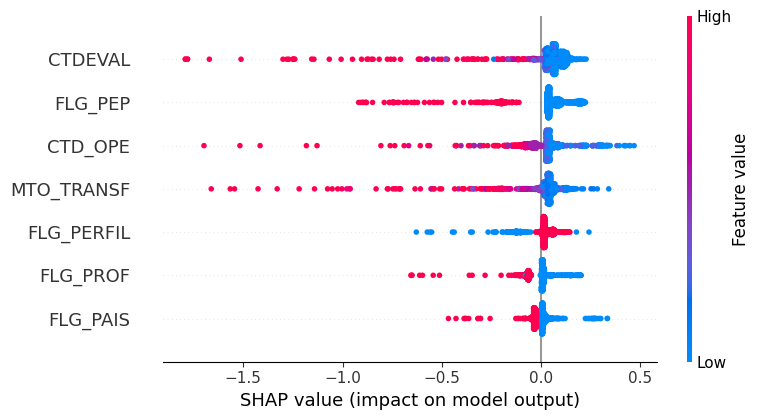

In [24]:
#Visualización shap value vs variable
shap.summary_plot(shap_values, df_sample[features])

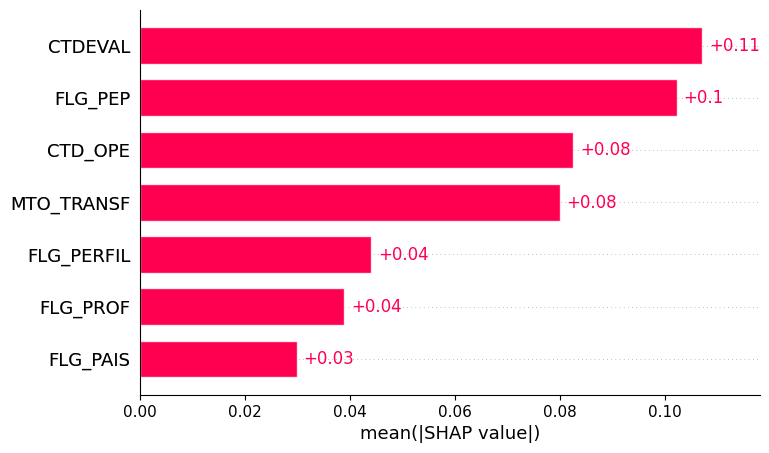

In [25]:
#Barplot de importancia de variable basados en el shap value.
shap.plots.bar(shap_values)

## 5. Siluetas

### 5.1 Todas las variables silueta 0.1

In [27]:
#Variables
ds1=dataseg[['MTO_TRANSF', 'CTD_OPE', 'FLG_PEP', 'FLG_PROF', 'FLG_PERFIL','CTDEVAL', 'FLG_PAIS']]

#Modelo base IF
iforest1 = IsolationForest(n_estimators = 500, contamination=0.1,random_state=7)
iforest1.fit(ds1)

#score de silueta
datasetv1 = dataseg.copy()
datasetv1['IF_LABEL']=iforest1.predict(ds1)
scoreSilhoutte = metrics.silhouette_score(ds1, datasetv1['IF_LABEL'], metric='euclidean') 
print('Silueta:',scoreSilhoutte)

#Casos estimados
datasetv1.groupby(['PERIODO','IF_LABEL']).size()

Silueta: 0.5258252251435743


PERIODO  IF_LABEL
202204   -1           25
          1          166
202205   -1           21
          1          198
202206   -1           16
          1          182
202207   -1           16
          1          155
202208   -1           21
          1          208
202209   -1           23
          1          186
dtype: int64

### 5.2 Todas las variables silueta 0.05

In [29]:
#Variables
ds2=dataseg[['MTO_TRANSF', 'CTD_OPE', 'FLG_PEP', 'FLG_PROF', 'FLG_PERFIL','CTDEVAL', 'FLG_PAIS']]

#Modelo base IF
iforest2 = IsolationForest(n_estimators = 500, contamination=0.05,random_state=7)
iforest2.fit(ds2)

#score de silueta
datasetv2 = dataseg.copy()
datasetv2['IF_LABEL']=iforest2.predict(ds2)
scoreSilhoutte = metrics.silhouette_score(ds2, datasetv2['IF_LABEL'], metric='euclidean') 
print('Silueta:',scoreSilhoutte)

#Casos estimados
datasetv2.groupby(['PERIODO','IF_LABEL']).size()

Silueta: 0.5738363390974353


PERIODO  IF_LABEL
202204   -1           11
          1          180
202205   -1           11
          1          208
202206   -1            7
          1          191
202207   -1            5
          1          166
202208   -1           14
          1          215
202209   -1           13
          1          196
dtype: int64

### 5.3 Todas las variables silueta 0.025

In [30]:
#Variables
ds3=dataseg[['MTO_TRANSF', 'CTD_OPE', 'FLG_PEP', 'FLG_PROF', 'FLG_PERFIL','CTDEVAL', 'FLG_PAIS']]

#Modelo base IF
iforest3 = IsolationForest(n_estimators = 500, contamination=0.025,random_state=7)
iforest3.fit(ds3)

#score de silueta
datasetv3 = dataseg.copy()
datasetv3['IF_LABEL']=iforest3.predict(ds3)
scoreSilhoutte = metrics.silhouette_score(ds3, datasetv3['IF_LABEL'], metric='euclidean') 
print('Silueta:',scoreSilhoutte)

#Casos estimados
datasetv3.groupby(['PERIODO','IF_LABEL']).size()

Silueta: 0.6106057308001671


PERIODO  IF_LABEL
202204   -1            6
          1          185
202205   -1            9
          1          210
202206   -1            3
          1          195
202207   -1            2
          1          169
202208   -1            4
          1          225
202209   -1            7
          1          202
dtype: int64

### 5.4 Todas las variables silueta 0.04 

In [31]:
#Variables
ds4=dataseg[['MTO_TRANSF', 'CTD_OPE', 'FLG_PEP', 'FLG_PROF', 'FLG_PERFIL','CTDEVAL', 'FLG_PAIS']]

#Modelo base IF
iforest4 = IsolationForest(n_estimators = 500, contamination=0.04,random_state=7)
iforest4.fit(ds4)

#score de silueta
datasetv4 = dataseg.copy()
datasetv4['IF_LABEL']=iforest4.predict(ds4)
scoreSilhoutte = metrics.silhouette_score(ds4, datasetv4['IF_LABEL'], metric='euclidean') 
print('Silueta:',scoreSilhoutte)

#Casos estimados
datasetv4.groupby(['PERIODO','IF_LABEL']).size()

Silueta: 0.5803950008877942


PERIODO  IF_LABEL
202204   -1           11
          1          180
202205   -1           10
          1          209
202206   -1            4
          1          194
202207   -1            4
          1          167
202208   -1            9
          1          220
202209   -1           10
          1          199
dtype: int64

### 5.5 Todas las variables silueta 0.03

In [32]:
#Variables
ds5=dataseg[['MTO_TRANSF', 'CTD_OPE', 'FLG_PEP', 'FLG_PROF', 'FLG_PERFIL','CTDEVAL', 'FLG_PAIS']]

#Modelo base IF
iforest5 = IsolationForest(n_estimators = 500, contamination=0.03,random_state=7)
iforest5.fit(ds5)

#score de silueta
datasetv5 = dataseg.copy()
datasetv5['IF_LABEL']=iforest5.predict(ds5)
scoreSilhoutte = metrics.silhouette_score(ds5, datasetv5['IF_LABEL'], metric='euclidean') 
print('Silueta:',scoreSilhoutte)

#Casos estimados
datasetv5.groupby(['PERIODO','IF_LABEL']).size()

Silueta: 0.6103707146838371


PERIODO  IF_LABEL
202204   -1            7
          1          184
202205   -1           10
          1          209
202206   -1            3
          1          195
202207   -1            3
          1          168
202208   -1            6
          1          223
202209   -1            8
          1          201
dtype: int64

### 5.6 Todas las variables silueta 0.08

In [33]:
#Variables
ds6=dataseg[['MTO_TRANSF', 'CTD_OPE', 'FLG_PEP', 'FLG_PROF', 'FLG_PERFIL','CTDEVAL', 'FLG_PAIS']]

#Modelo base IF
iforest6 = IsolationForest(n_estimators = 500, contamination=0.08,random_state=7)
iforest6.fit(ds6)

#score de silueta
datasetv6 = dataseg.copy()
datasetv6['IF_LABEL']=iforest6.predict(ds6)
scoreSilhoutte = metrics.silhouette_score(ds6, datasetv6['IF_LABEL'], metric='euclidean') 
print('Silueta:',scoreSilhoutte)

#Casos estimados
datasetv6.groupby(['PERIODO','IF_LABEL']).size()

Silueta: 0.5633976274008196


PERIODO  IF_LABEL
202204   -1           19
          1          172
202205   -1           18
          1          201
202206   -1           11
          1          187
202207   -1           12
          1          159
202208   -1           20
          1          209
202209   -1           18
          1          191
dtype: int64

### 5.7 Todas las variables silueta 0.07

In [34]:
#Variables
ds7=dataseg[['MTO_TRANSF', 'CTD_OPE', 'FLG_PEP', 'FLG_PROF', 'FLG_PERFIL','CTDEVAL', 'FLG_PAIS']]

#Modelo base IF
iforest7 = IsolationForest(n_estimators = 500, contamination=0.07,random_state=7)
iforest7.fit(ds7)

#score de silueta
datasetv7 = dataseg.copy()
datasetv7['IF_LABEL']=iforest7.predict(ds7)
scoreSilhoutte = metrics.silhouette_score(ds7, datasetv7['IF_LABEL'], metric='euclidean') 
print('Silueta:',scoreSilhoutte)

#Casos estimados
datasetv7.groupby(['PERIODO','IF_LABEL']).size()

Silueta: 0.57832541820157


PERIODO  IF_LABEL
202204   -1           16
          1          175
202205   -1           15
          1          204
202206   -1           10
          1          188
202207   -1           11
          1          160
202208   -1           18
          1          211
202209   -1           16
          1          193
dtype: int64